# Here, I want to see where exactly I find cosmics, and if this is somehow correlated with something

In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
import re as regex
getobmt = lambda path: int(regex.search("(?<=OBMT_START_)[0-9]+",path).group(0))
import os
import sys
sys.path.insert(0, os.path.abspath('../../lib/TrackObs/'))
import TrackObs as tobs

In [3]:
def make_heatmap(obslist):
    # get all the cosmics from obslist, make them into a mask and throw them onto an empty array
    obs = obslist[0]
    mask = np.zeros((obs.srcAL, obs.srcAC))

    for obs in obslist:
        for ii in range(len(obs.data)):
            track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
            start_AL = obs.data[ii]["LOC_AL"]
            stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
            start_AC = obs.data[ii]["LOC_AC"]
            stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
            track[track!=0] = 1
            mask[start_AL:stop_AL,start_AC:stop_AC] += track
            
    return mask

def make_low_heatmap(obslist):
    # get all the cosmics from obslist, make them into a mask and throw them onto an empty array
    obs = obslist[0]
    mask = np.zeros((obs.srcAL, obs.srcAC))

    for obs in obslist:
        for ii in range(len(obs.data)):
            if obs.data[ii]["TRACK_EN"]<2000:  # these seem to be photon noise
                track = np.reshape(obs.data[ii]["TRACK"], (obs.data[ii]["DIM_AL"],obs.data[ii]["DIM_AC"]))
                start_AL = obs.data[ii]["LOC_AL"]
                stop_AL = obs.data[ii]["LOC_AL"] + obs.data[ii]["DIM_AL"]
                start_AC = obs.data[ii]["LOC_AC"]
                stop_AC = obs.data[ii]["LOC_AC"] + obs.data[ii]["DIM_AC"]
                track[track!=0] = 1
                mask[start_AL:stop_AL,start_AC:stop_AC] += track
            
    return mask

# BAM-OBS FOV1

In [28]:
# get data

## BAM
prefix = "../bam/output/2017-07-03_cross_erosion/"
bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS1" in file]
bamfiles.sort(key=getobmt)

## BAM-SIF - everything
#prefix = '../bam_sif/output/'
#bamfiles = [prefix+file for file in os.listdir(prefix) if "SIF2" in file]


obslist = []

for ii in range(len(bamfiles)):
    obslist += tobs.read_Obslist_fits(bamfiles[ii])
    
ncosmics1 = 0
for obs in obslist:
    ncosmics1 += len(obs.data)
    
print("Got", len(obslist), "observations, containing", ncosmics1, "cosmics")

mask1 = make_heatmap(obslist)

Got 3457 observations, containing 314947 cosmics


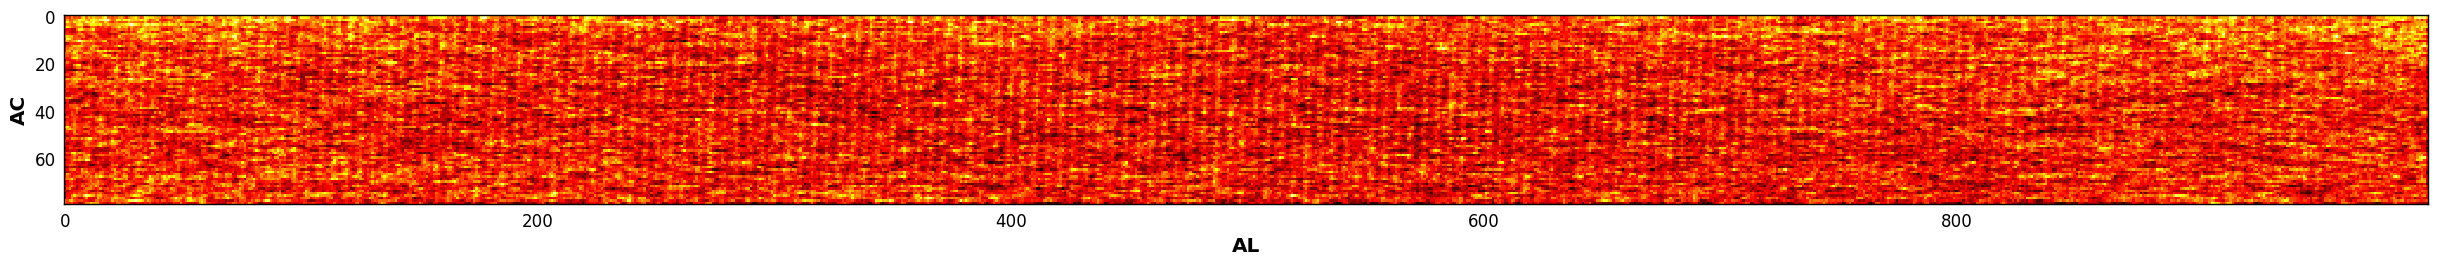

In [29]:
im=np.rot90(mask1,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='hot')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

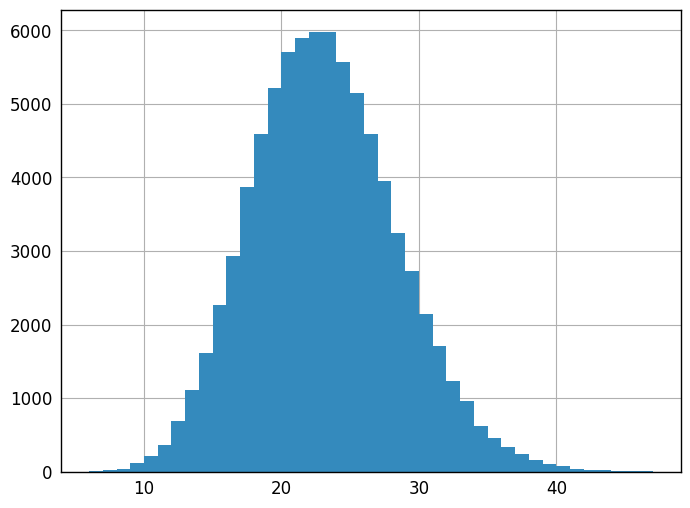

In [31]:
test = plt.hist(mask1.flatten(),41)

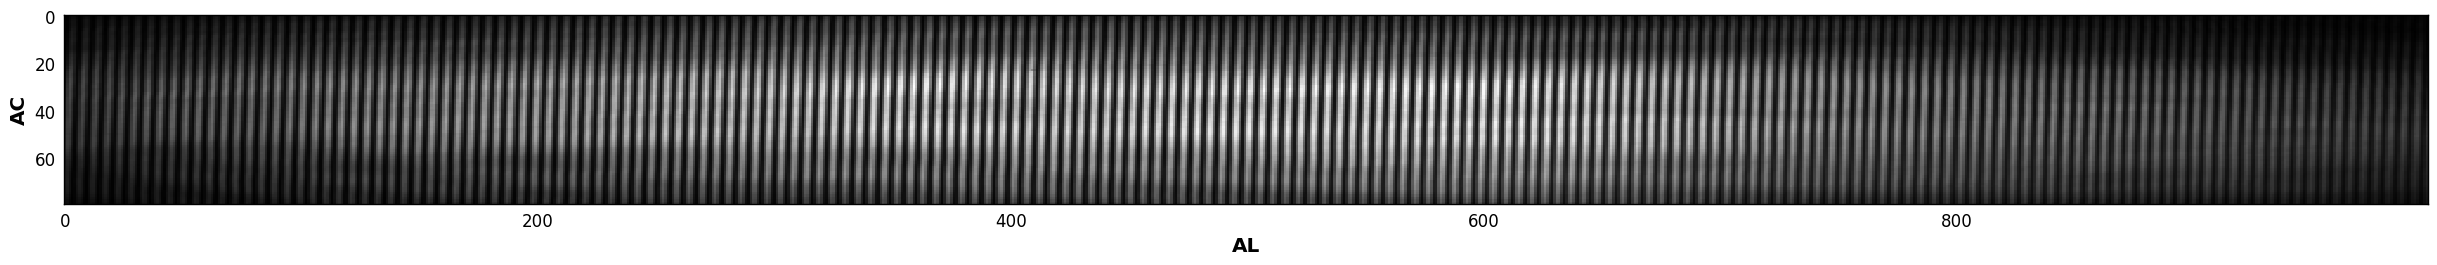

In [56]:
# compare with the background

from astropy.io import fits

hdulist = fits.open("../verification/fake_bam_obs.fits")
pattern = hdulist[1].data
hdulist.close

im=np.rot90(pattern,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

# BAM-OBS FOV2

In [32]:
prefix = "../bam/output/2017-07-03_cross_erosion/"
bamfiles = [prefix+file for file in os.listdir(prefix) if "OBS2" in file]
bamfiles.sort(key=getobmt)

obslist = []

for ii in range(len(bamfiles)):
    obslist += tobs.read_Obslist_fits(bamfiles[ii])

    
ncosmics2 = 0
for obs in obslist:
    ncosmics2 += len(obs.data)
    
print("Got", len(obslist), "observations, containing", ncosmics2, "cosmics")

mask2 = make_heatmap(obslist)

Got 3457 observations, containing 313245 cosmics


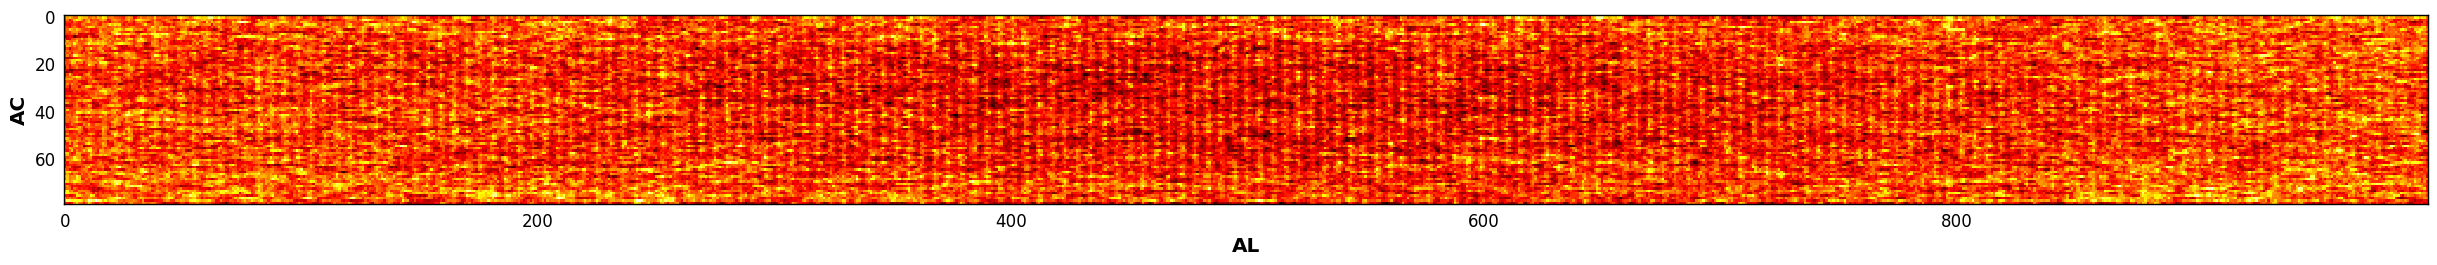

In [33]:
im=np.rot90(mask2,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='hot')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

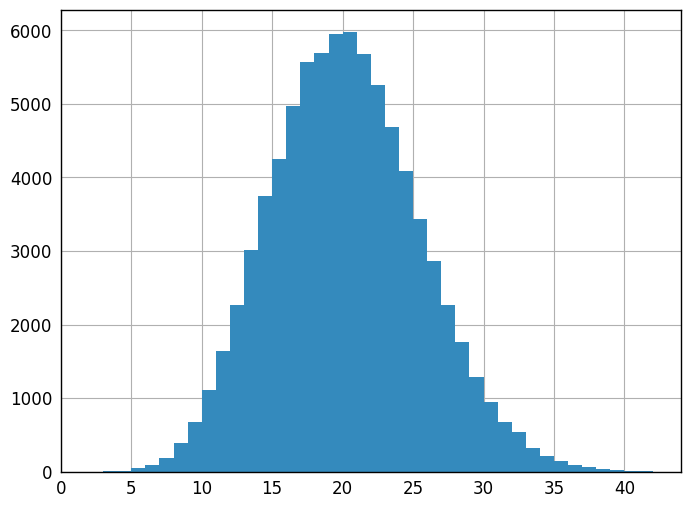

In [12]:
test = plt.hist(mask2.flatten(),40)

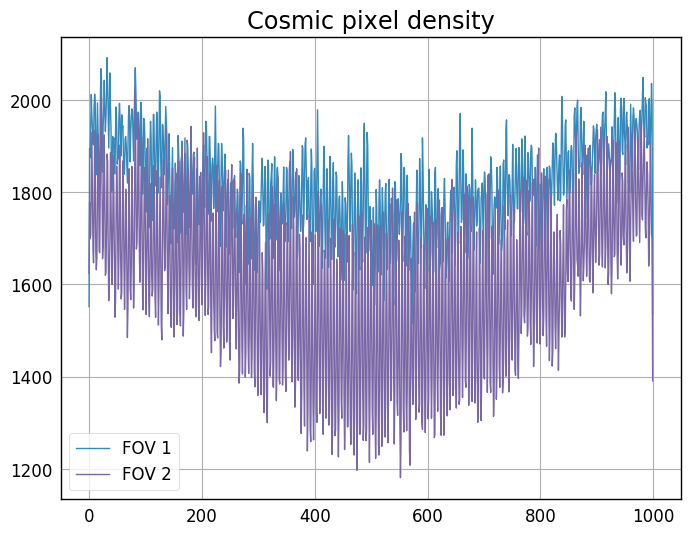

In [34]:
plt.plot(np.sum(mask1, axis=1), label="FOV 1")
plt.plot(np.sum(mask2, axis=1), label="FOV 2")
plt.title("Cosmic pixel density")
plt.legend(loc="best")

-> Clear modulation due to the pattern, stronger in FOV 2!

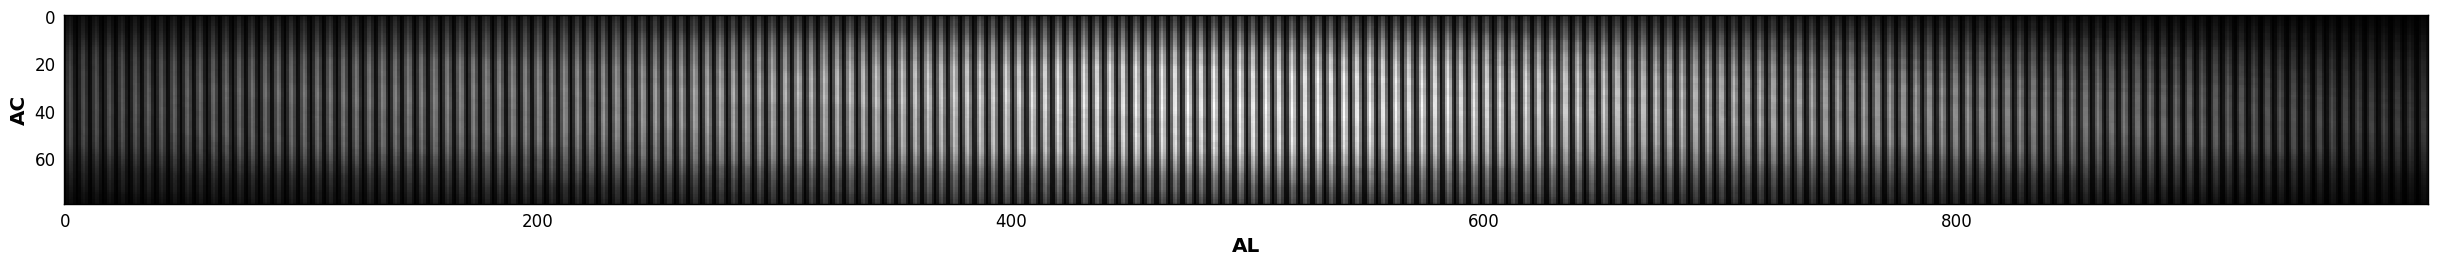

In [60]:
from astropy.io import fits

hdulist = fits.open("../verification/fake_bam_obs.fits")
pattern = hdulist[10].data
hdulist.close

im=np.rot90(pattern,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='gray')
plt.gcf().set_size_inches(30.5, 5.5)
#plt.colorbar(orientation="horizontal")
plt.grid(False)

## Result:

In BAM-OBS, we certainly see that we have some detections associated with the pattern - althought whether it is that we preferentially detect off-pattern (limited sensitiivty) or on-pattern (misdetections), has to be checked out. On visual comparison with my previously extracted patterns, it seems to be the former - especially when log-plotting the heatmaps, we also see that in the center of the patterns (where they're brightest), we detect the least cosmics.

(The histograms look very poissonian, which makes sense)

As for the fake/questionable (i.e. under 2000 ADU) detections: I notice that these are crowded towards the edges and not necessarily on-pattern - they actually seem to be off-fringe, like the others.
Especially in FOV 1, they are strongly focused towards the edges - my algorithm should not care where they are, but those could just be cut-off cosmics.

In [35]:
print("Total cosmic pixels in FOV 1:", np.sum(mask1))
print("Total detected cosmics in FOV 1:", np.sum(ncosmics1))
print()
print("Total pixels in FOV 2:", np.sum(mask2))
print("Total detected cosmics in FOV 2:", np.sum(ncosmics2))
print()
print("Ratio of pixels (1/2):", np.sum(mask1)/np.sum(mask2))
print("Ratio of cosmics (1/2):", ncosmics1/ncosmics2)

Total cosmic pixels in FOV 1: 1811294.0
Total detected cosmics in FOV 1: 314947

Total pixels in FOV 2: 1603364.0
Total detected cosmics in FOV 2: 313245

Ratio of pixels (1/2): 1.12968359025
Ratio of cosmics (1/2): 1.005433446663155


After reconnection-modifications, we now see the same amount of cosmics, but less pixels. Interesting, I suppose that parts of the cosmics are simply hidden by the pattern, e.g. we get offsets towards lower energies? The energy-histograms (other notebook) don't seem to support this.

# BAM-SIF FOV1

In [46]:
## BAM-SIF - everything
prefix = '../bam_sif/output/'
bamfiles = [prefix+file for file in os.listdir(prefix) if "SIF1" in file]


obslist = []

for ii in range(len(bamfiles)):
    obslist += tobs.read_Obslist_fits(bamfiles[ii])
    
print("Got", len(obslist), "observations")

mask1s = make_heatmap(obslist)

Got 1483 observations


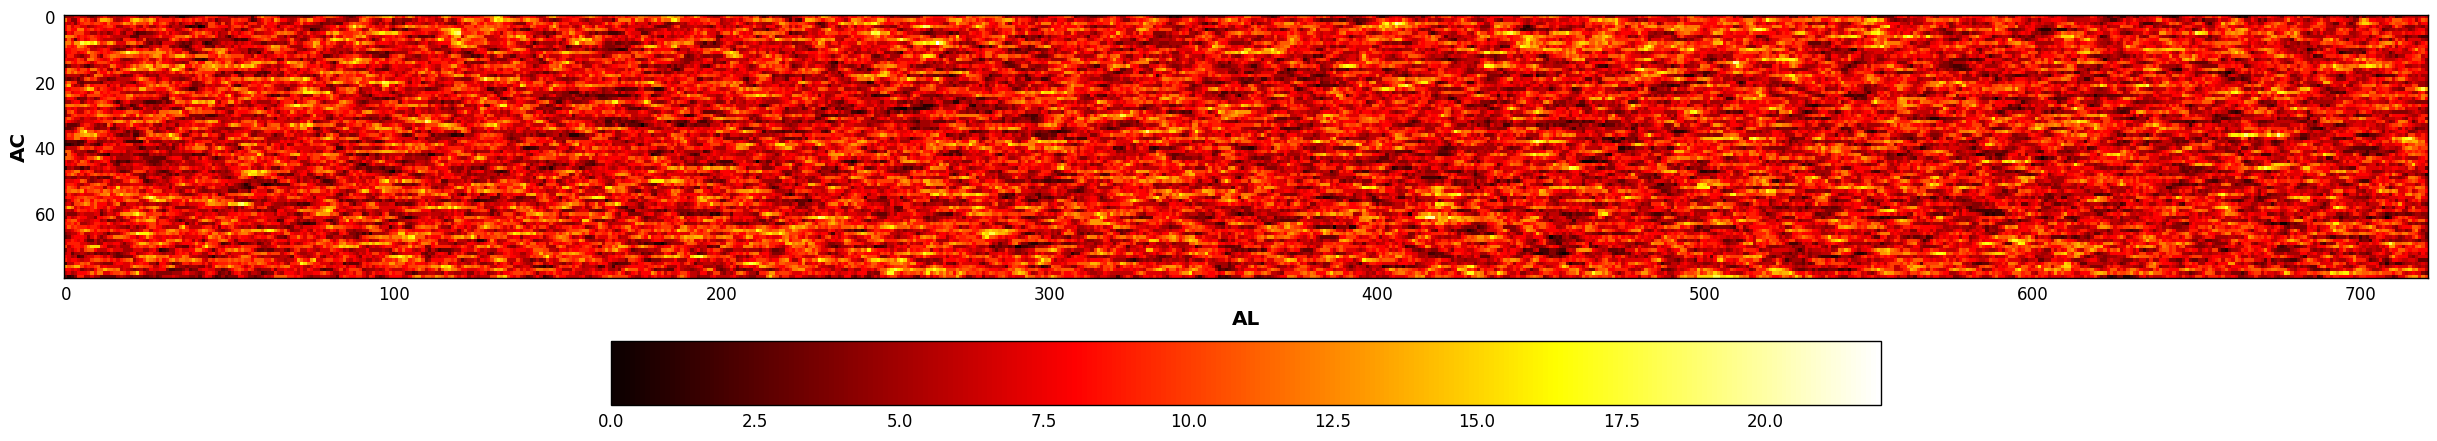

In [47]:
im=np.rot90(mask1s,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='hot')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

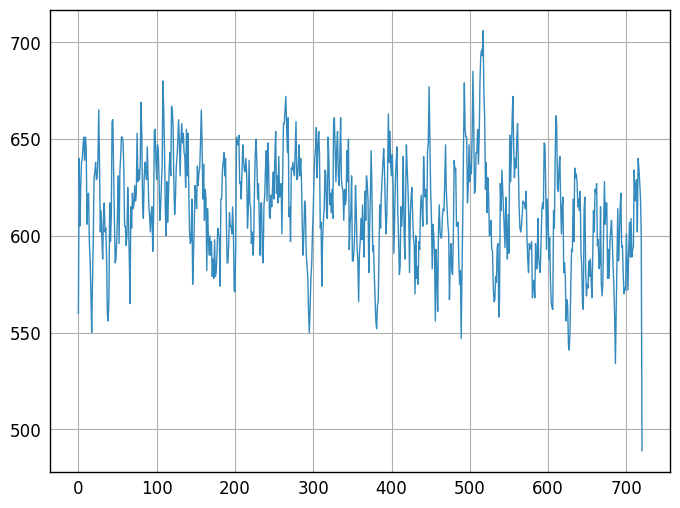

In [50]:
plt.plot(np.sum(mask1s, axis=1))

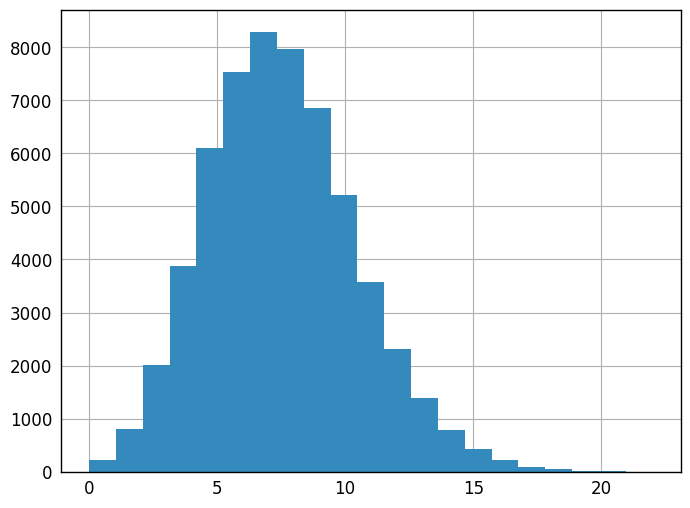

In [51]:
test = plt.hist(mask1s.flatten(),21)

Not seeing a lot of structure here.

# BAM-SIF FOV2

In [52]:
## BAM-SIF - everything
prefix = '../bam_sif/output/'
bamfiles = [prefix+file for file in os.listdir(prefix) if "SIF2" in file]


obslist = []

for ii in range(len(bamfiles)):
    obslist += tobs.read_Obslist_fits(bamfiles[ii])
    
print("Got", len(obslist), "observations")

mask2s = make_heatmap(obslist)

Got 1483 observations


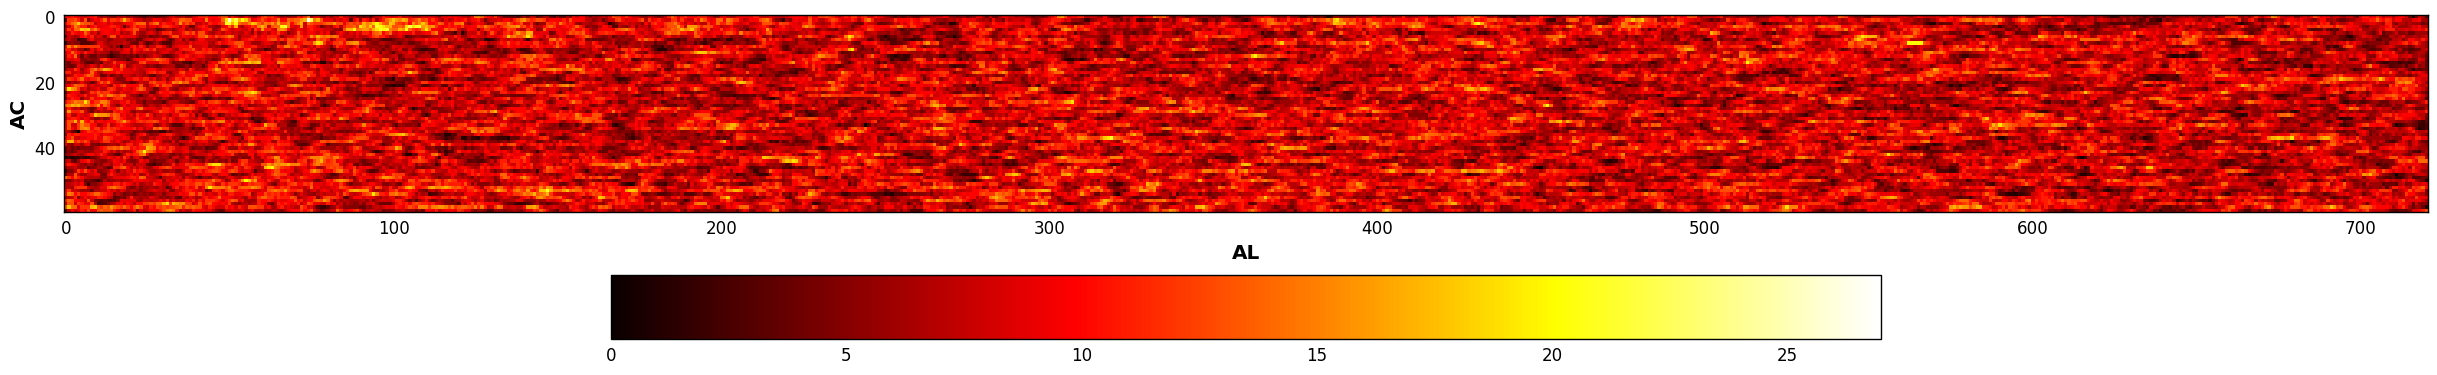

In [53]:
im=np.rot90(mask2s,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.imshow(im, cmap='hot')
plt.gcf().set_size_inches(30.5, 5.5)
plt.colorbar(orientation="horizontal")
plt.grid(False)

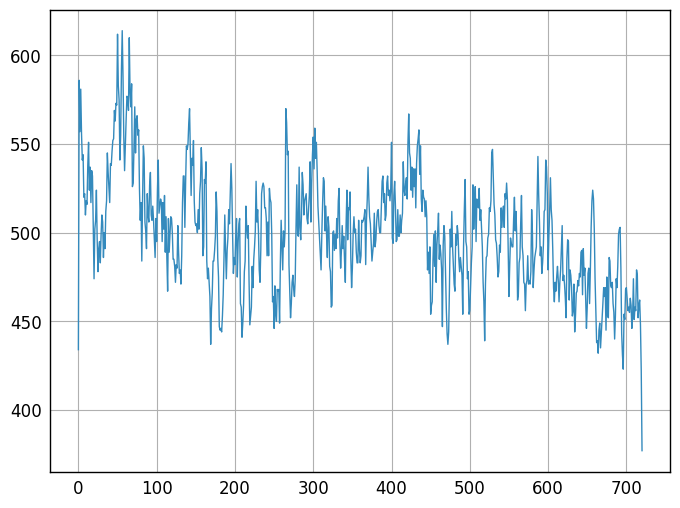

In [54]:
plt.plot(np.sum(mask2s, axis=1))

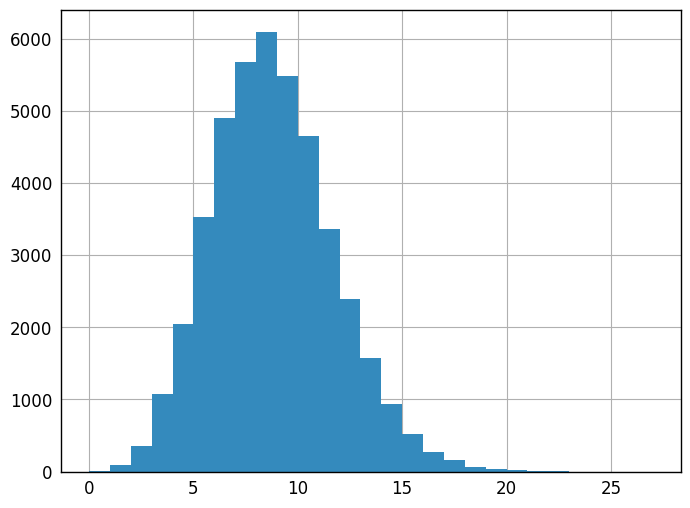

In [55]:
test = plt.hist(mask2s.flatten(),27)

I do not see any pattern in either here.

About the < 2000 eV patterns: Some of them look like they're genuinely low energy, but there's again a crowding towards the edges - are these cut-off cosmics? Also, there don't appear to be any more of them on FOV 2 than on 1

In [46]:
# a simple test to reproduce my energy distros
E = []
# simulate a few particle species of different flux with different dE/dX
nparts = [3000,5000,5000,10000,5000,3000]
dEdX = [4,6,10,9,8,7,6.5] # another way would be to randomly roll the dEdX from some distro
thickness = 1 # of the CCD - does not really matter


for ii in range(len(nparts)):
    angles = np.random.random(nparts[ii])*np.pi/2 # only need from 0 to 90 deg, these are the entrance angles
    pathlen = thickness/np.sin(angles)
    E += list(pathlen*dEdX[ii])

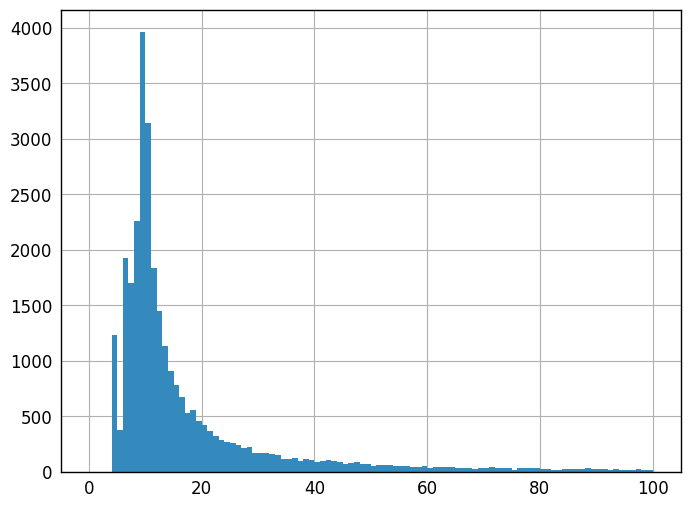

In [47]:
test = plt.hist(E,100, range=(0,100))